In [ ]:
!pip3 install datasets
!pip install textstat
!pip install shap

In [ ]:
# Environment setup
import os
import random
import json
import ast

# Core libraries
import numpy as np
import pandas as pd
from datasets import load_dataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, issparse, csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

# Explainability
import shap

# Readability features
import textstat

# Google Drive
from google.colab import drive

# Set reproducibility
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = "42"

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation ARC (https://www.kaggle.com/datasets/jeromeblanchet/arc-ai2-reasoning-challenge/data)

In [ ]:
def load_json_data(base_path):
    rows = []
    for difficulty in ["Easy", "Challenge"]:
        for split in ["Train", "Dev", "Test"]:
            jsonl_file = os.path.join(base_path, f"ARC-{difficulty}-{split}.jsonl")
            if not os.path.exists(jsonl_file):
                continue

            with open(jsonl_file, "r", encoding="utf-8") as f:
                for line in f:
                    data = json.loads(line)
                    q = data.get("question", {})
                    row = {
                        "id": data.get("id"),
                        "question": q.get("stem"),
                        "choices": [c["text"] for c in q.get("choices", [])],
                        "answer": data.get("answerKey"),
                        "difficulty": difficulty.lower()
                    }
                    rows.append(row)

    return pd.DataFrame(rows)

# Load grade info from CSVs
def load_csv_grades(base_path):
    grade_rows = []
    for difficulty in ["Easy", "Challenge"]:
        for split in ["Train", "Dev", "Test"]:
            csv_path = os.path.join(base_path, f"ARC-{difficulty}-{split}.csv")
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                df = df.rename(columns={"questionID": "id", "schoolGrade": "grade"})
                grade_rows.append(df[["id", "grade"]])
    return pd.concat(grade_rows, ignore_index=True)

# Convert grade to lower/upper category
def assign_grade_group(grade):
    try:
        g = int(grade)
        if 3 <= g <= 5:
            return "lower"
        elif 7 <= g <= 9:
            return "upper"
        else:
            return None
    except:
        return None

def get_answer_text(row):
    labels = ['A', 'B', 'C', 'D']
    answer = row['answer']

    try:
        # If answer is a letter like "C"
        if isinstance(answer, str) and answer.strip().upper() in labels:
            index = labels.index(answer.strip().upper())

        # If answer is a number like "3"
        elif isinstance(answer, str) and answer.strip().isdigit():
            index = int(answer.strip()) - 1

        else:
            return None  # invalid or unknown format

        # Safely return the corresponding choice
        if 0 <= index < len(row['choices']):
            return row['choices'][index]
        else:
            return None  # index out of bounds

    except:
        return None  # catch any unexpected errors


base_path = "/content/drive/My Drive/Master Thesis/ARC/Data"

# Load and merge
json_df = load_json_data(base_path)
csv_df = load_csv_grades(base_path)
df = pd.merge(json_df, csv_df, on="id", how="inner")

# Drop bad rows
df = df.dropna(subset=["question", "choices", "answer", "grade"])

# Assign grade group and remove others
df["grade_group"] = df["grade"].apply(assign_grade_group)
df = df.dropna(subset=["grade_group"])

# Convert answer key to answer text
df["answer_text"] = df.apply(get_answer_text, axis=1)
df = df.dropna(subset=["answer_text"])
df = df.drop(columns=["answer"])

# Split train/test
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df["grade_group"], random_state=42
)

# Verify a few samples
def verify_merge_correctness(df, n=3):
    sample = df.sample(n)
    for _, row in sample.iterrows():
        print(f"ID: {row['id']}")
        print(f"Grade: {row['grade']} (Group: {row['grade_group']})")
        print(f"Difficulty: {row['difficulty']}")
        print(f"Question: {row['question']}")
        print(f"Choices: {row['choices']}")
        print(f"Answer Text: {row['answer_text']}")
        print("="*80)

verify_merge_correctness(df, n=3)
train_df

ID: Mercury_7044783
Grade: 8 (Group: upper)
Difficulty: easy
Question: The rate at which a wave passes through a medium is known as its
Choices: ['speed.', 'amplitude.', 'acceleration.', 'wavelength.']
Answer Text: speed.
ID: NYSEDREGENTS_2015_4_4
Grade: 4 (Group: lower)
Difficulty: easy
Question: Which two terms are used to describe weather?
Choices: ['wind direction and amount of erosion', 'gravity and amount of rain', 'groundwater and cloud cover', 'air temperature and wind speed']
Answer Text: air temperature and wind speed
ID: Mercury_SC_413638
Grade: 5 (Group: lower)
Difficulty: easy
Question: Which two things are produced when a plant breaks down sugar to release energy?
Choices: ['carbon dioxide and water', 'oxygen and carbon dioxide', 'carbon dioxide and food', 'oxygen and food']
Answer Text: carbon dioxide and water


,id,question,choices,difficulty,grade,grade_group,answer_text
7432,Mercury_402341,"In what order are the Sun, Moon, and Earth dur...","[Earth-Moon-Sun, Earth-Sun-Moon, Moon-Sun-Eart...",challenge,8,upper,Moon-Earth-Sun
208,Mercury_SC_401223,A shallow container of salt water is placed in...,"[All of the mixture will evaporate., The salt ...",easy,5,lower,Only the water will evaporate and the salt wil...
5034,Mercury_SC_401602,A model of the Moon would be different from a ...,"[be smaller than Earth., have a source of ligh...",easy,5,lower,be smaller than Earth.
4609,NYSEDREGENTS_2012_8_11,Which health condition is an infectious disease?,"[pneumonia caused by microorganisms, heart pro...",easy,8,upper,pneumonia caused by microorganisms
2039,MCAS_2007_5_4799,Which of the following forms of energy can tra...,"[electrical, light, magnetic, sound]",easy,5,lower,sound
...,...,...,...,...,...,...,...
6386,Mercury_7029505,How do blood types differ from one another in ...,"[different sizes of red blood cells, different...",challenge,8,upper,different marker proteins on red blood cells
735,Mercury_7201128,Amylase is a chemical that decomposes starch i...,"[as an inhibitor of insulin production, as an ...",easy,9,upper,as an enzyme that aids in digestion
2902,Mercury_7041335,Which of these traits is most influenced by en...,"[weight, hair color, blood type, handedness]",easy,8,upper,weight
5368,Mercury_7201688,Sooj learned that whales use vocalization to n...,"[alteration of whale genetic material, reverse...",challenge,9,upper,separation of whale family groups


### Majority Class Baseline

In [ ]:
def majority_class_baseline(df):
    most_common = df["grade_group"].value_counts().idxmax()
    baseline_acc = df["grade_group"].value_counts().max() / len(df) * 100
    print(f"Majority Class Baseline: Always Predict '{most_common}' → Accuracy: {baseline_acc:.2f}%")


print("ARC Dataset Majority Class Baseline:")
majority_class_baseline(test_df)

ARC Dataset Majority Class Baseline:
Majority Class Baseline: Always Predict 'upper' → Accuracy: 64.10%


In [ ]:
def majority_class_macro_f1(y_true):
    most_common = y_true.value_counts().idxmax()
    y_pred = [most_common] * len(y_true)
    return most_common, f1_score(y_true, y_pred, average='macro')

most_common, macro_f1_baseline = majority_class_macro_f1(test_df["grade_group"])
print(f"Majority Class Baseline (Macro F1): Always Predict '{most_common}' → F1-score: {macro_f1_baseline:.4f}")

Majority Class Baseline (Macro F1): Always Predict 'upper' → F1-score: 0.3906


#### Baseline

In [ ]:
def vectorize_data(train_df, test_df):
    # Vectorizes combined text (question + answer + article for RACE) using TF-IDF.
    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x))
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x))

    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")

    X_train = vectorizer.fit_transform(train_df["combined_text"])
    X_test = vectorizer.transform(test_df["combined_text"])

    y_train = train_df["grade_group"]
    y_test = test_df["grade_group"]

    return X_train, X_test, y_train, y_test, vectorizer


def train_baseline(X_train, X_test, y_train, y_test, vectorizer, model, model_name):
    # Trains baseline classifiers and evaluates them on both train and test sets.
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_preds)

    test_preds = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_preds)

    print(f"\n{model_name} Performance:")
    print(f"Train Accuracy: {train_acc:.4f}")
    print(classification_report(y_train, train_preds))

    print(f"Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, test_preds))

    return model

In [ ]:
X_train, X_test, y_train, y_test, vectorizer = vectorize_data(train_df, test_df)
models = {
        "Logistic Regression": LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "Decision Tree": DecisionTreeClassifier(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "KNN": KNeighborsClassifier(),
        "SVM": LinearSVC(random_state=42)
        }

print("\nBaseline Models for ARC (80-20 split):")
for model_name in models:
  train_baseline(X_train, X_test, y_train, y_test, vectorizer, models[model_name], model_name)


Baseline Models for ARC (80-20 split):

Logistic Regression Performance:
Train Accuracy: 0.8732
              precision    recall  f1-score   support

       lower       0.78      0.90      0.84      2160
       upper       0.94      0.86      0.90      3856

    accuracy                           0.87      6016
   macro avg       0.86      0.88      0.87      6016
weighted avg       0.88      0.87      0.87      6016

Test Accuracy: 0.7806
              precision    recall  f1-score   support

       lower       0.67      0.76      0.71       540
       upper       0.85      0.79      0.82       964

    accuracy                           0.78      1504
   macro avg       0.76      0.78      0.77      1504
weighted avg       0.79      0.78      0.78      1504


Naive Bayes Performance:
Train Accuracy: 0.8546
              precision    recall  f1-score   support

       lower       0.86      0.72      0.78      2160
       upper       0.85      0.93      0.89      3856

    accuracy  

### Improving the Baseline Model

*   Lowering C value in LR to fix under-regularization.

Fix overfitting for Tree Models (good for feature importance):

*  max_depth=5 Limits depth prevents the tree from growing too deep and memorizing
*  min_samples_leaf=10 each leaf must have at least 10 examples, reducing splits on noise
*  n_estimators=100 (RF) More trees helps Random Forest generalize better by averaging

In [ ]:
X_train, X_test, y_train, y_test, vectorizer = vectorize_data(train_df, test_df)
improved_models = {
        "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "KNN": KNeighborsClassifier(),
        "SVM": LinearSVC(random_state=42),
        "Decision Tree": DecisionTreeClassifier(
                          class_weight="balanced",
                          max_depth=20,
                          min_samples_leaf=3,
                          random_state=42
                          ),
        "Random Forest": RandomForestClassifier(
                            class_weight="balanced",
                            n_estimators=300,
                            max_depth=15,
                            min_samples_leaf=5,
                            random_state=42,
                            n_jobs=-1
                            )
        }

print("\nImproved Baseline Models for ARC (80-20 split):")
for model_name in improved_models:
  train_baseline(X_train, X_test, y_train, y_test, vectorizer, improved_models[model_name], model_name)


Improved Baseline Models for ARC (80-20 split):

Logistic Regression Performance:
Train Accuracy: 0.7982
              precision    recall  f1-score   support

       lower       0.68      0.82      0.74      2160
       upper       0.89      0.79      0.83      3856

    accuracy                           0.80      6016
   macro avg       0.78      0.80      0.79      6016
weighted avg       0.81      0.80      0.80      6016

Test Accuracy: 0.7453
              precision    recall  f1-score   support

       lower       0.63      0.73      0.67       540
       upper       0.83      0.76      0.79       964

    accuracy                           0.75      1504
   macro avg       0.73      0.74      0.73      1504
weighted avg       0.76      0.75      0.75      1504


Naive Bayes Performance:
Train Accuracy: 0.8546
              precision    recall  f1-score   support

       lower       0.86      0.72      0.78      2160
       upper       0.85      0.93      0.89      3856

    a

#Extra Features

## Length-based

*   Question Length
*   Average Choice Length



In [ ]:
def count_words(text):
    # Returns the number of words in a string.
    return len(text.split()) if isinstance(text, str) else 0

def avg_choice_length(choices):
    # Returns the average number of words across all choices (list of strings).
    if isinstance(choices, list) and all(isinstance(c, str) for c in choices):
        lengths = [count_words(c) for c in choices]
        return sum(lengths) / len(lengths) if lengths else 0
    return 0

def extract_length_features(df):
    # Adds word count features for question, answer, and choices.
    df["question_length"] = df["question"].apply(count_words)
    df["avg_choice_length"] = df["choices"].apply(avg_choice_length)

    return df

## Lexical Complexity


*   Average Word Length
*   Lexical Diversity (unique words/total words)



In [ ]:
def average_word_length(text):
    # Returns the average word length in a given text.
    if isinstance(text, str):
        words = text.split()
        return sum(len(word) for word in words) / len(words) if words else 0
    return 0

def lexical_diversity(text):
    # Returns the lexical diversity (unique words / total words) in a given text.
    if isinstance(text, str):
        words = text.split()
        return len(set(words)) / len(words) if words else 0
    return 0

def extract_lexical_features(df):
    # Adds lexical complexity features like avg word length and lexical diversity.
    df["avg_word_length"] = df["question"].apply(average_word_length)
    df["lexical_diversity"] = df["question"].apply(lexical_diversity)

    return df



## Readability Features

*   Flesch Reading Ease Score (Higher = Easier)
*   Flesch-Kincaid Grade Level (Higher = Harder)



In [ ]:
def calculate_flesch_reading_ease(text):
    return max(textstat.flesch_reading_ease(text), 0) if isinstance(text, str) else 0

def calculate_flesch_kincaid_grade(text):
    return max(textstat.flesch_kincaid_grade(text), 0) if isinstance(text, str) else 0

def extract_readability_features(df):
    # Adds readability features to the dataframe.
    df["flesch_reading_ease"] = df["question"].apply(calculate_flesch_reading_ease)
    df["flesch_kincaid_grade"] = df["question"].apply(calculate_flesch_kincaid_grade)

    return df

## Baseline with Features

In [ ]:
def vectorize_and_add_features(train_df, test_df):
    #Vectorizes text using TF-IDF and adds additional numeric features.

    train_df = extract_length_features(train_df)
    test_df = extract_length_features(test_df)

    train_df = extract_lexical_features(train_df)
    test_df = extract_lexical_features(test_df)

    train_df = extract_readability_features(train_df)
    test_df = extract_readability_features(test_df)

    train_df["combined_text"] = train_df["question"] + " " + train_df["choices"].apply(lambda x: " ".join(x))
    test_df["combined_text"] = test_df["question"] + " " + test_df["choices"].apply(lambda x: " ".join(x))

    vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
    X_train_text = vectorizer.fit_transform(train_df["combined_text"])
    X_test_text = vectorizer.transform(test_df["combined_text"])

    feature_cols = ["question_length", "avg_choice_length", "flesch_reading_ease",
                    "flesch_kincaid_grade", "avg_word_length", "lexical_diversity"]

    X_train_features = train_df[feature_cols].values
    X_test_features = test_df[feature_cols].values

    X_train = hstack([X_train_text, X_train_features])
    X_test = hstack([X_test_text, X_test_features])

    y_train = train_df["grade_group"]
    y_test = test_df["grade_group"]

    return X_train, X_test, y_train, y_test, vectorizer

In [ ]:
X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_features(train_df, test_df)
improved_models = {
        "Logistic Regression": LogisticRegression(C=0.05, class_weight="balanced", max_iter=1000, random_state=42),
        "Naive Bayes": MultinomialNB(),
        "KNN": KNeighborsClassifier(),
        "SVM": LinearSVC(random_state=42),
        "Decision Tree": DecisionTreeClassifier(
                          class_weight="balanced",
                          max_depth=20,
                          min_samples_leaf=3,
                          random_state=42
                          ),
        "Random Forest": RandomForestClassifier(
                            class_weight="balanced",
                            n_estimators=300,
                            max_depth=15,
                            min_samples_leaf=5,
                            random_state=42,
                            n_jobs=-1
                            )
        }

print("\nImproved Baseline Models with features for ARC (80-20 split):")
for model_name in improved_models:
  train_baseline(X_train, X_test, y_train, y_test, vectorizer, improved_models[model_name], model_name)


Improved Baseline Models with features for ARC (80-20 split):

Logistic Regression Performance:
Train Accuracy: 0.7106
              precision    recall  f1-score   support

       lower       0.58      0.72      0.64      2160
       upper       0.82      0.71      0.76      3856

    accuracy                           0.71      6016
   macro avg       0.70      0.71      0.70      6016
weighted avg       0.73      0.71      0.72      6016

Test Accuracy: 0.7094
              precision    recall  f1-score   support

       lower       0.58      0.73      0.64       540
       upper       0.82      0.70      0.75       964

    accuracy                           0.71      1504
   macro avg       0.70      0.71      0.70      1504
weighted avg       0.73      0.71      0.71      1504


Naive Bayes Performance:
Train Accuracy: 0.7252
              precision    recall  f1-score   support

       lower       0.60      0.69      0.64      2160
       upper       0.81      0.74      0.78   

### Features Importance

# Shap Values

In [ ]:
def plot_shap_summary_arc(model, X_sparse, vectorizer, extra_feature_array=None, extra_feature_names=None, target_class="upper", title="SHAP-Plot: RACE"):
    # Combine feature names
    tfidf_feature_names = [f'"{w}"' for w in vectorizer.get_feature_names_out()]
    if extra_feature_names:
        feature_names = tfidf_feature_names + extra_feature_names
    else:
        feature_names = tfidf_feature_names

    # Convert X to dense and combine
    X_dense = X_sparse.toarray() if issparse(X_sparse) else np.asarray(X_sparse)
    X_combined = np.hstack([X_dense, extra_feature_array]) if extra_feature_array is not None else X_dense

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_combined)

    # Get correct class index
    if isinstance(shap_values, list):
        class_idx = list(model.classes_).index(target_class)
        shap_values = shap_values[class_idx]
    elif shap_values.ndim == 3:
        class_idx = list(model.classes_).index(target_class)
        shap_values = shap_values[:, :, class_idx]

    # Plot
    shap.summary_plot(shap_values, X_combined, feature_names=feature_names, show=True)



Random Forest Performance:
Train Accuracy: 0.7709
              precision    recall  f1-score   support

       lower       0.65      0.77      0.71      2160
       upper       0.86      0.77      0.81      3856

    accuracy                           0.77      6016
   macro avg       0.76      0.77      0.76      6016
weighted avg       0.78      0.77      0.77      6016

Test Accuracy: 0.7447
              precision    recall  f1-score   support

       lower       0.62      0.75      0.68       540
       upper       0.84      0.74      0.79       964

    accuracy                           0.74      1504
   macro avg       0.73      0.75      0.73      1504
weighted avg       0.76      0.74      0.75      1504



/tmp/ipython-input-16-1468437578.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_combined, feature_names=feature_names, show=True)


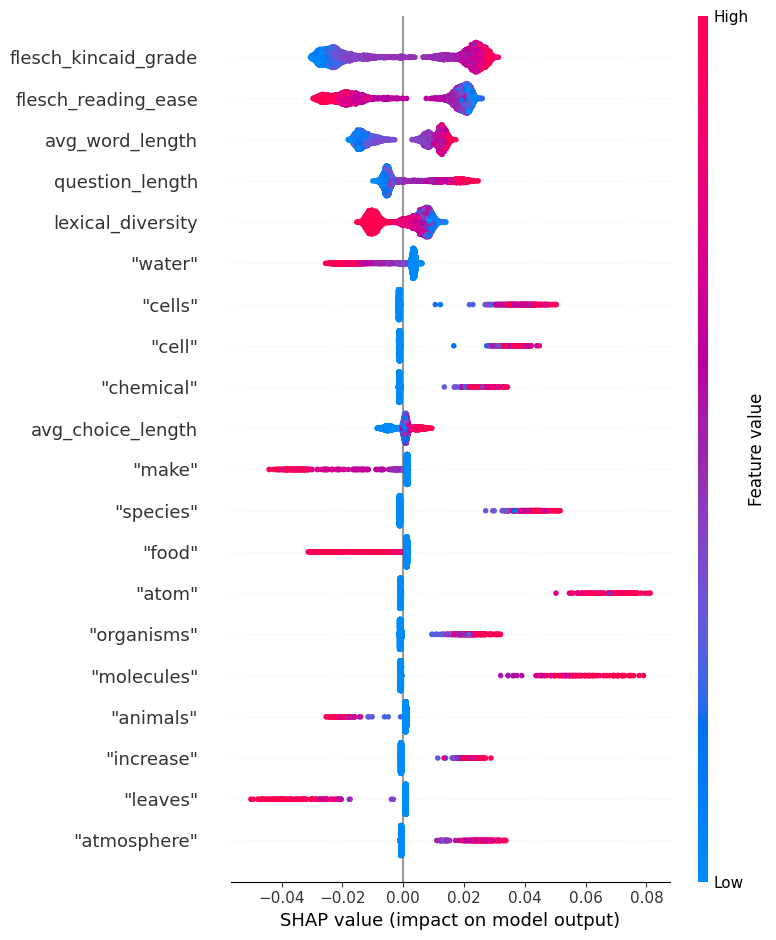

In [ ]:
# Vectorize data
X_train, X_test, y_train, y_test, vectorizer = vectorize_and_add_features(train_df, test_df)

# Train Random Forest
rf_model = train_baseline(
    X_train, X_test, y_train, y_test,
    vectorizer, improved_models['Random Forest'],
    'Random Forest'
)

# Extra features
extra_features = ["question_length", "avg_choice_length", "flesch_reading_ease",
                  "flesch_kincaid_grade", "avg_word_length", "lexical_diversity"]

# Create inputs
X_train = csr_matrix(X_train)
n_tfidf = len(vectorizer.get_feature_names_out())
X_tfidf = X_train[:, :n_tfidf]
X_extra = X_train[:, n_tfidf:].toarray()


plot_shap_summary_arc(
    rf_model,
    X_tfidf,
    vectorizer,
    extra_feature_array=X_extra,
    extra_feature_names=extra_features,
    title="SHAP-Plot ARC"
)